In [32]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from skimage.metrics import structural_similarity as ssim

In [33]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [34]:
data_path = "../data/2nd_dataset_COVID_19_Radiography_Dataset/data"

In [35]:
dataset = torchvision.datasets.ImageFolder(root=data_path, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [36]:
len(dataset)

21165

In [37]:
Counter(dataset.targets)

Counter({0: 10192, 1: 10973})

In [38]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

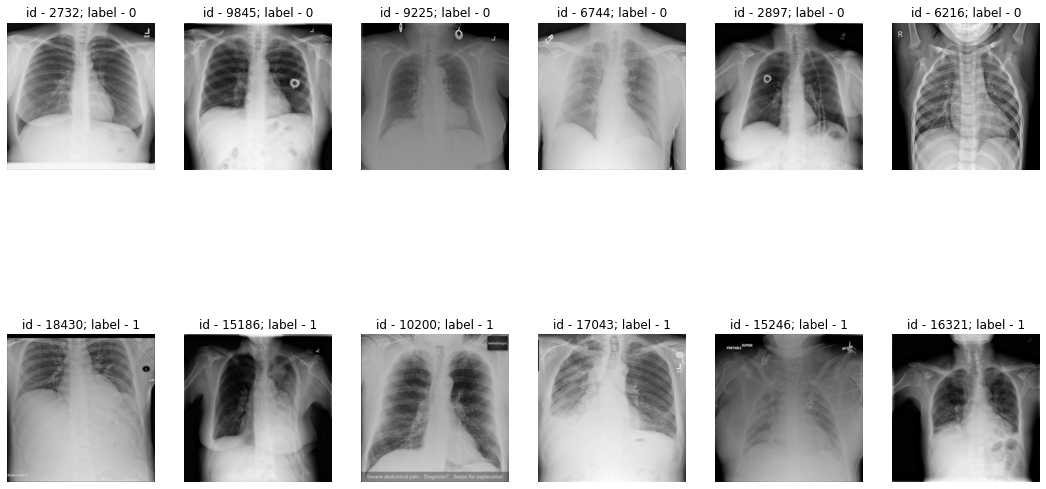

In [39]:
visualize_classes(dataset)

In [40]:
dataset = torchvision.datasets.ImageFolder(
    root=data_path, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [41]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

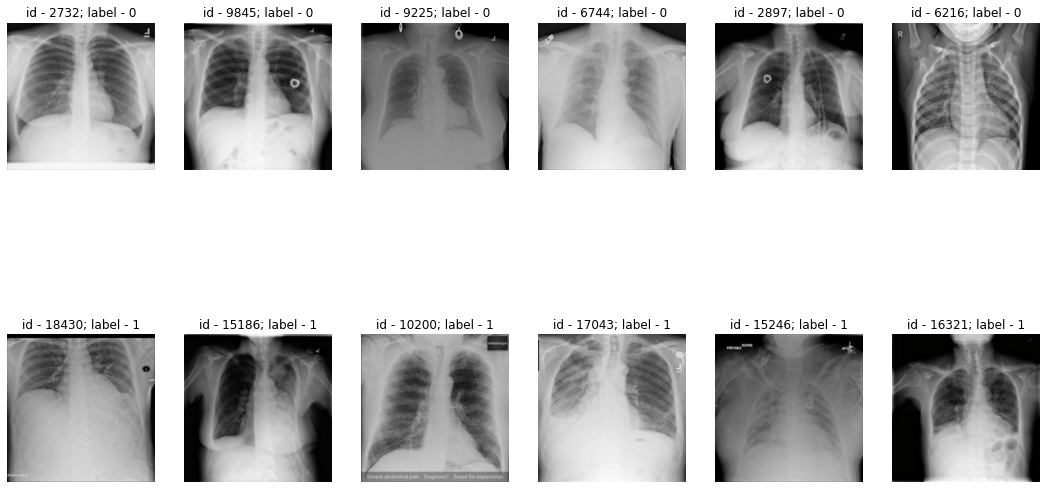

In [42]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [43]:
device = "cuda:0"
# device = "cpu"

In [44]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [45]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=0
)

### Load model

In [46]:
save_path = "../models/4.1_resnet18_2021-04-28_15:01:18.pt"

In [47]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Analyze results

In [48]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 133/133 [00:20<00:00,  6.45it/s]


In [49]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [50]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [51]:
df["error_type"] = df.apply(error_class, axis=1)

In [52]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,307,307,307
FP,131,131,131
TN,1858,1858,1858
TP,1937,1937,1937


In [53]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.8965272856130404
average_precision_score - 0.8810362494880691


In [54]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [55]:
df

,true,pred,prob,error_type
0,0,0,0.014220,TN
1,1,1,0.998375,TP
2,1,1,0.994056,TP
3,1,1,0.996494,TP
4,0,0,0.015694,TN
...,...,...,...,...
4228,0,0,0.006488,TN
4229,0,0,0.000167,TN
4230,1,1,0.732158,TP
4231,1,1,0.993955,TP


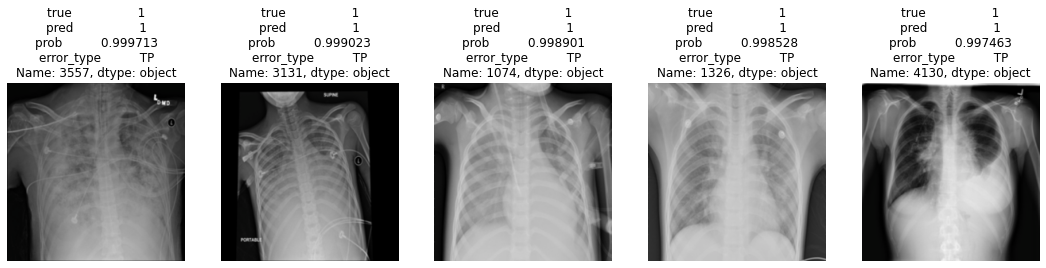

In [56]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

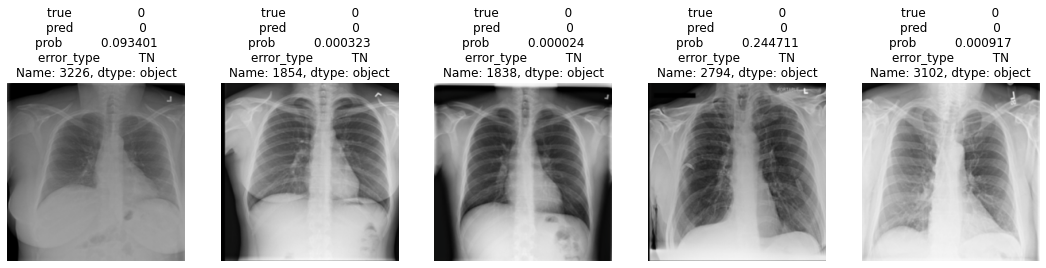

In [57]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

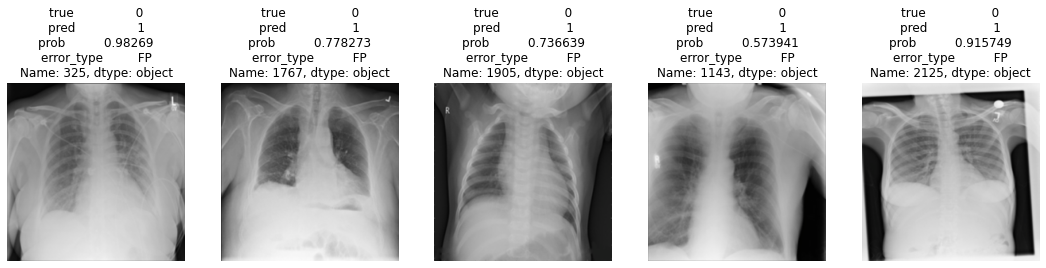

In [58]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

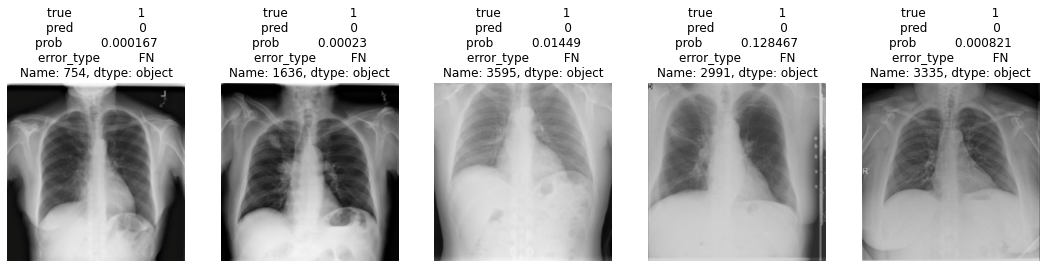

In [59]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Attacks

In [60]:
# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [61]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

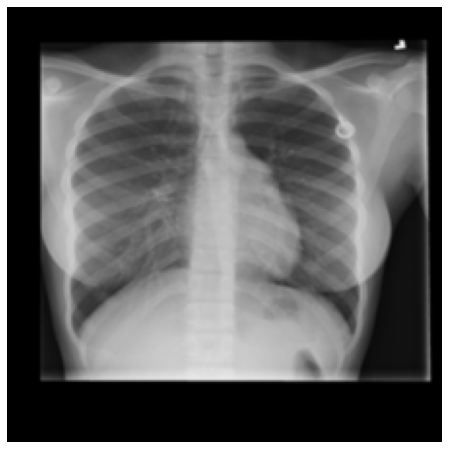

0.00016684723

In [62]:
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

#### Art wrapper

In [63]:
from art.estimators.classification import PyTorchClassifier

In [64]:
art_classifier = PyTorchClassifier(
    model=model, 
    loss=nn.CrossEntropyLoss(), 
    input_shape=(3, 244, 244), 
    nb_classes=2
)

In [65]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
output = art_classifier.predict(image)[0, 1]
print(output)

0.00016684723


#### Loss gradient 

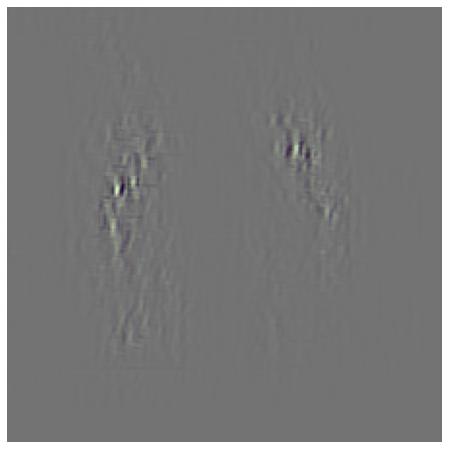

In [66]:
loss_gradient = art_classifier.loss_gradient(x=image, y=to_categorical([1], nb_classes=2))[0].permute(1, 2, 0).cpu().numpy()

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8))
plt.imshow(loss_gradient_plot)
plt.axis('off')
plt.show()

In [67]:
def norms(image, image_adv):
    img_original = inv_normalize(torch.tensor(image[0].cpu())).numpy() * 255
    img_adv = inv_normalize(torch.tensor(image_adv[0])).numpy() * 255

    l_0 = int(99*len(np.where(np.abs(img_original - img_adv)>0.5)[0]) / (224*224*3)) + 1   
    l_1 = int(99*np.sum(np.abs(img_original - img_adv)) / np.sum(np.abs(img_original))) + 1
    l_2 = int(99*np.linalg.norm(img_original - img_adv) / np.linalg.norm(img_original)) + 1 
    l_inf = int(99*np.max(np.abs(img_original - img_adv)) / 255) + 1

    print('Perturbation l_0 norm: %d%%' % l_0)
    print('Perturbation l_1 norm: %d%%' % l_1)
    print('Perturbation l_2 norm: %d%%' % l_2)
    print('Noise l_inf norm: %d%%' % l_inf)

    # Let's also plot the absolute amount of adversarial pixel perturbations:
    pert = img_original - img_adv
    pert_min = np.min(pert)
    pert_max = np.max(pert)

    plt.figure(figsize=(8,8))
    img_to_show = (pert - pert_min) / (pert_max - pert_min)
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

### Metrics

#### Original data

In [68]:
def get_misclassification_rate(df):
    errors = df.groupby("error_type").count().T.iloc[0]
    misclassification_rate = (errors["FP"] + errors["FN"]) / errors.sum() * 100
    return misclassification_rate

In [69]:
def get_robustness_to_gaussian_blur(df_blur, df_orig):
    robustness_to_gaussian_blur = len(df_blur[df_blur["pred"]!=df_blur["true"]]) / len(df_orig[df_orig["pred"]!=df_orig["true"]])
    return robustness_to_gaussian_blur

In [70]:
def get_av_ssim(orig_images, adv_images):
    values = []
    for i in tqdm(range(len(orig_images))):
        values.append(ssim(np.transpose(orig_images[i], (1, 2, 0)), np.transpose(adv_images[i], (1, 2, 0)), multichannel=True))
    return np.mean(values)

In [71]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [72]:
def get_preds(adv = None, batch_size=1, max_iter=None):
    prob = []
    pred = []
    true = []
#     images = []
#     original_images = []
    
    if max_iter is not None:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=True, num_workers=1
        )
    else:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
        )
    counter = 0
    for image, label in tqdm(loader, total=max_iter if max_iter is not None else len(loader)):
#         if max_iter is not None:
#             original_images.append(np.array(image[0]).copy())
        if adv is not None:
            image = adv.generate(image.cpu(), y=to_categorical([1-label], nb_classes=2))
        pred_adv = art_classifier.predict(image)[:,1].reshape(-1)
        prob.extend(list(pred_adv))
        pred.extend(list((pred_adv > 0.5).astype(int)))
        true.extend(list(label.numpy().reshape(-1)))
#         images.append(np.array(image[0]))
        if max_iter is not None:
            counter += 1
            if counter >= max_iter:
                break

    df = pd.DataFrame({"prob":prob, "pred":pred, "true":true})
    df["error_type"] = df.apply(error_class, axis=1)
    return df
    if max_iter is not None:
        return df, np.array(images), np.array(original_images)
    else:
        return df, np.array(images)

In [74]:
df_orig = get_preds()

100%|██████████| 4233/4233 [00:35<00:00, 119.27it/s]


In [75]:
misclassification_rate = get_misclassification_rate(df_orig)
misclassification_rate

10.347271438695959

In [76]:
# df_orig_blur, orig_blur_images = get_preds(blur=True)

In [77]:
# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_orig_blur, df_orig)
# robustness_to_gaussian_blur

In [78]:
# misclassification_rate = get_misclassification_rate(df_orig_blur)
# misclassification_rate

In [79]:
# average_ssim = get_av_ssim(orig_images, orig_blur_images)
# average_ssim

#### ProjectedGradientDescent

In [80]:
adv = ProjectedGradientDescent(art_classifier, targeted=True, max_iter=50, eps_step=1, eps=0.02)

In [83]:
df_pgd = get_preds(adv, batch_size=1, max_iter=111)

  0%|          | 0/111 [00:00<?, ?it/s]

  1%|          | 1/111 [00:00<01:32,  1.18it/s]

  2%|▏         | 2/111 [00:01<01:24,  1.29it/s]

  3%|▎         | 3/111 [00:02<01:17,  1.39it/s]

  4%|▎         | 4/111 [00:02<01:12,  1.47it/s]

  5%|▍         | 5/111 [00:03<01:10,  1.50it/s]

  5%|▌         | 6/111 [00:03<01:07,  1.56it/s]

  6%|▋         | 7/111 [00:04<01:06,  1.57it/s]

  7%|▋         | 8/111 [00:05<01:05,  1.58it/s]

  8%|▊         | 9/111 [00:05<01:06,  1.54it/s]

  9%|▉         | 10/111 [00:06<01:02,  1.62it/s]

 10%|▉         | 11/111 [00:06<01:03,  1.59it/s]

 11%|█         | 12/111 [00:07<01:00,  1.64it/s]

 12%|█▏        | 13/111 [00:08<01:01,  1.59it/s]

 13%|█▎        | 14/111 [00:08<01:02,  1.54it/s]

 14%|█▎        | 15/111 [00:09<01:02,  1.54it/s]

 14%|█▍        | 16/111 [00:10<01:01,  1.55it/s]

 15%|█▌        | 17/111 [00:10<01:02,  1.50it/s]

 16%|█▌        | 18/111 [00:11<01:00,  1.53it/s]

 17%|█▋        | 19/111 [00:12<00:59,  1.54it/s]

 18%|█▊        | 20/111 [00:12<00:59,  1.53it/s]

 19%|█▉        | 21/111 [00:13<00:58,  1.55it/s]

 20%|█▉        | 22/111 [00:14<00:55,  1.60it/s]

 21%|██        | 23/111 [00:14<00:55,  1.58it/s]

 22%|██▏       | 24/111 [00:15<00:55,  1.58it/s]

 23%|██▎       | 25/111 [00:15<00:54,  1.59it/s]

 23%|██▎       | 26/111 [00:16<00:55,  1.52it/s]

 24%|██▍       | 27/111 [00:17<00:54,  1.53it/s]

 25%|██▌       | 28/111 [00:17<00:52,  1.58it/s]

 26%|██▌       | 29/111 [00:18<00:51,  1.60it/s]

 27%|██▋       | 30/111 [00:19<00:53,  1.52it/s]

 28%|██▊       | 31/111 [00:19<00:50,  1.59it/s]

 29%|██▉       | 32/111 [00:20<00:52,  1.50it/s]

 30%|██▉       | 33/111 [00:21<00:51,  1.53it/s]

 31%|███       | 34/111 [00:21<00:49,  1.54it/s]

 32%|███▏      | 35/111 [00:22<00:49,  1.55it/s]

 32%|███▏      | 36/111 [00:23<00:49,  1.51it/s]

 33%|███▎      | 37/111 [00:23<00:47,  1.55it/s]

 34%|███▍      | 38/111 [00:24<00:48,  1.50it/s]

 35%|███▌      | 39/111 [00:25<00:47,  1.51it/s]

 36%|███▌      | 40/111 [00:25<00:46,  1.51it/s]

 37%|███▋      | 41/111 [00:26<00:46,  1.51it/s]

 38%|███▊      | 42/111 [00:27<00:45,  1.51it/s]

 39%|███▊      | 43/111 [00:27<00:45,  1.51it/s]

 40%|███▉      | 44/111 [00:28<00:44,  1.49it/s]

 41%|████      | 45/111 [00:29<00:42,  1.54it/s]

 41%|████▏     | 46/111 [00:29<00:42,  1.54it/s]

 42%|████▏     | 47/111 [00:30<00:39,  1.60it/s]

 43%|████▎     | 48/111 [00:30<00:39,  1.60it/s]

 44%|████▍     | 49/111 [00:31<00:37,  1.66it/s]

 45%|████▌     | 50/111 [00:32<00:35,  1.72it/s]

 46%|████▌     | 51/111 [00:32<00:36,  1.63it/s]

 47%|████▋     | 52/111 [00:33<00:37,  1.59it/s]

 48%|████▊     | 53/111 [00:33<00:36,  1.60it/s]

 49%|████▊     | 54/111 [00:34<00:36,  1.58it/s]

 50%|████▉     | 55/111 [00:35<00:35,  1.59it/s]

 50%|█████     | 56/111 [00:35<00:34,  1.58it/s]

 51%|█████▏    | 57/111 [00:36<00:35,  1.54it/s]

 52%|█████▏    | 58/111 [00:37<00:34,  1.55it/s]

 53%|█████▎    | 59/111 [00:37<00:34,  1.51it/s]

 54%|█████▍    | 60/111 [00:38<00:34,  1.49it/s]

 55%|█████▍    | 61/111 [00:39<00:32,  1.53it/s]

 56%|█████▌    | 62/111 [00:39<00:33,  1.48it/s]

 57%|█████▋    | 63/111 [00:40<00:31,  1.52it/s]

 58%|█████▊    | 64/111 [00:41<00:30,  1.53it/s]

 59%|█████▊    | 65/111 [00:41<00:29,  1.53it/s]

 59%|█████▉    | 66/111 [00:42<00:29,  1.51it/s]

 60%|██████    | 67/111 [00:43<00:28,  1.52it/s]

 61%|██████▏   | 68/111 [00:43<00:27,  1.55it/s]

 62%|██████▏   | 69/111 [00:44<00:26,  1.57it/s]

 63%|██████▎   | 70/111 [00:45<00:26,  1.56it/s]

 64%|██████▍   | 71/111 [00:45<00:25,  1.56it/s]

 65%|██████▍   | 72/111 [00:46<00:25,  1.55it/s]

 66%|██████▌   | 73/111 [00:47<00:25,  1.49it/s]

 67%|██████▋   | 74/111 [00:47<00:24,  1.48it/s]

 68%|██████▊   | 75/111 [00:48<00:23,  1.52it/s]

 68%|██████▊   | 76/111 [00:49<00:22,  1.54it/s]

 69%|██████▉   | 77/111 [00:49<00:21,  1.58it/s]

 70%|███████   | 78/111 [00:50<00:21,  1.54it/s]

 71%|███████   | 79/111 [00:50<00:20,  1.56it/s]

 72%|███████▏  | 80/111 [00:51<00:19,  1.59it/s]

 73%|███████▎  | 81/111 [00:52<00:19,  1.57it/s]

 74%|███████▍  | 82/111 [00:52<00:18,  1.56it/s]

 75%|███████▍  | 83/111 [00:53<00:18,  1.52it/s]

 76%|███████▌  | 84/111 [00:54<00:17,  1.53it/s]

 77%|███████▋  | 85/111 [00:54<00:17,  1.50it/s]

 77%|███████▋  | 86/111 [00:55<00:16,  1.53it/s]

 78%|███████▊  | 87/111 [00:56<00:15,  1.55it/s]

 79%|███████▉  | 88/111 [00:56<00:14,  1.55it/s]

 80%|████████  | 89/111 [00:57<00:14,  1.52it/s]

 81%|████████  | 90/111 [00:58<00:14,  1.49it/s]

 82%|████████▏ | 91/111 [00:58<00:13,  1.48it/s]

 83%|████████▎ | 92/111 [00:59<00:13,  1.45it/s]

 84%|████████▍ | 93/111 [01:00<00:12,  1.49it/s]

 85%|████████▍ | 94/111 [01:00<00:11,  1.45it/s]

 86%|████████▌ | 95/111 [01:01<00:10,  1.48it/s]

 86%|████████▋ | 96/111 [01:02<00:10,  1.50it/s]

 87%|████████▋ | 97/111 [01:02<00:09,  1.50it/s]

 88%|████████▊ | 98/111 [01:03<00:08,  1.54it/s]

 89%|████████▉ | 99/111 [01:04<00:07,  1.52it/s]

 90%|█████████ | 100/111 [01:04<00:07,  1.56it/s]

 91%|█████████ | 101/111 [01:05<00:06,  1.57it/s]

 92%|█████████▏| 102/111 [01:06<00:05,  1.56it/s]

 93%|█████████▎| 103/111 [01:06<00:05,  1.54it/s]

 94%|█████████▎| 104/111 [01:07<00:04,  1.55it/s]

 95%|█████████▍| 105/111 [01:08<00:03,  1.54it/s]

 95%|█████████▌| 106/111 [01:08<00:03,  1.55it/s]

 96%|█████████▋| 107/111 [01:09<00:02,  1.51it/s]

 97%|█████████▋| 108/111 [01:10<00:01,  1.50it/s]

 98%|█████████▊| 109/111 [01:10<00:01,  1.46it/s]

 99%|█████████▉| 110/111 [01:11<00:00,  1.52it/s]

 99%|█████████▉| 110/111 [01:12<00:00,  1.53it/s]


In [84]:
# df_pgd_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [85]:
misclassification_rate = get_misclassification_rate(df_pgd)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_pgd_blur, df_pgd)

# average_ssim = get_av_ssim(orig_images, pgd_images)

In [86]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

63.96396396396396

#### BasicIterativeMethod

In [87]:
from art.attacks.evasion import BasicIterativeMethod, ElasticNet, FastGradientMethod

In [88]:
adv = BasicIterativeMethod(art_classifier, eps = 0.1, eps_step = 0.1, max_iter = 100, targeted = True)

In [89]:
df_bim = get_preds(adv, batch_size=1, max_iter=111)

  0%|          | 0/111 [00:00<?, ?it/s]

  1%|          | 1/111 [00:01<02:29,  1.36s/it]

  2%|▏         | 2/111 [00:02<02:24,  1.32s/it]

  3%|▎         | 3/111 [00:03<02:19,  1.29s/it]

  4%|▎         | 4/111 [00:05<02:15,  1.26s/it]

  5%|▍         | 5/111 [00:06<02:11,  1.24s/it]

  5%|▌         | 6/111 [00:07<02:08,  1.23s/it]

  6%|▋         | 7/111 [00:08<02:08,  1.23s/it]

  7%|▋         | 8/111 [00:09<02:06,  1.22s/it]

  8%|▊         | 9/111 [00:11<02:03,  1.21s/it]

  9%|▉         | 10/111 [00:12<02:07,  1.26s/it]

 10%|▉         | 11/111 [00:13<02:01,  1.21s/it]

 11%|█         | 12/111 [00:14<01:59,  1.21s/it]

 12%|█▏        | 13/111 [00:15<01:56,  1.19s/it]

 13%|█▎        | 14/111 [00:17<02:01,  1.25s/it]

 14%|█▎        | 15/111 [00:18<02:00,  1.26s/it]

 14%|█▍        | 16/111 [00:19<01:57,  1.24s/it]

 15%|█▌        | 17/111 [00:20<01:55,  1.23s/it]

 16%|█▌        | 18/111 [00:22<01:52,  1.20s/it]

 17%|█▋        | 19/111 [00:23<01:49,  1.19s/it]

 18%|█▊        | 20/111 [00:24<01:46,  1.17s/it]

 19%|█▉        | 21/111 [00:25<01:46,  1.18s/it]

 20%|█▉        | 22/111 [00:26<01:46,  1.19s/it]

 21%|██        | 23/111 [00:28<01:47,  1.22s/it]

 22%|██▏       | 24/111 [00:29<01:45,  1.22s/it]

 23%|██▎       | 25/111 [00:30<01:43,  1.20s/it]

 23%|██▎       | 26/111 [00:31<01:43,  1.22s/it]

 24%|██▍       | 27/111 [00:32<01:42,  1.22s/it]

 25%|██▌       | 28/111 [00:34<01:41,  1.22s/it]

 26%|██▌       | 29/111 [00:35<01:38,  1.20s/it]

 27%|██▋       | 30/111 [00:36<01:36,  1.19s/it]

 28%|██▊       | 31/111 [00:37<01:34,  1.18s/it]

 29%|██▉       | 32/111 [00:38<01:33,  1.19s/it]

 30%|██▉       | 33/111 [00:40<01:34,  1.21s/it]

 31%|███       | 34/111 [00:41<01:33,  1.22s/it]

 32%|███▏      | 35/111 [00:42<01:31,  1.21s/it]

 32%|███▏      | 36/111 [00:43<01:32,  1.23s/it]

 33%|███▎      | 37/111 [00:44<01:27,  1.19s/it]

 34%|███▍      | 38/111 [00:46<01:27,  1.20s/it]

 35%|███▌      | 39/111 [00:47<01:26,  1.20s/it]

 36%|███▌      | 40/111 [00:48<01:24,  1.19s/it]

 37%|███▋      | 41/111 [00:49<01:23,  1.20s/it]

 38%|███▊      | 42/111 [00:50<01:22,  1.20s/it]

 39%|███▊      | 43/111 [00:52<01:23,  1.23s/it]

 40%|███▉      | 44/111 [00:53<01:22,  1.24s/it]

 41%|████      | 45/111 [00:54<01:20,  1.23s/it]

 41%|████▏     | 46/111 [00:55<01:18,  1.21s/it]

 42%|████▏     | 47/111 [00:56<01:17,  1.20s/it]

 43%|████▎     | 48/111 [00:58<01:17,  1.23s/it]

 44%|████▍     | 49/111 [00:59<01:17,  1.25s/it]

 45%|████▌     | 50/111 [01:00<01:16,  1.25s/it]

 46%|████▌     | 51/111 [01:02<01:15,  1.25s/it]

 47%|████▋     | 52/111 [01:03<01:12,  1.23s/it]

 48%|████▊     | 53/111 [01:04<01:12,  1.25s/it]

 49%|████▊     | 54/111 [01:05<01:12,  1.27s/it]

 50%|████▉     | 55/111 [01:07<01:08,  1.23s/it]

 50%|█████     | 56/111 [01:08<01:08,  1.24s/it]

 51%|█████▏    | 57/111 [01:09<01:04,  1.20s/it]

 52%|█████▏    | 58/111 [01:10<01:05,  1.23s/it]

 53%|█████▎    | 59/111 [01:11<01:02,  1.21s/it]

 54%|█████▍    | 60/111 [01:13<01:01,  1.20s/it]

 55%|█████▍    | 61/111 [01:14<00:59,  1.20s/it]

 56%|█████▌    | 62/111 [01:15<00:59,  1.22s/it]

 57%|█████▋    | 63/111 [01:16<00:58,  1.22s/it]

 58%|█████▊    | 64/111 [01:17<00:57,  1.23s/it]

 59%|█████▊    | 65/111 [01:19<00:56,  1.24s/it]

 59%|█████▉    | 66/111 [01:20<00:56,  1.25s/it]

 60%|██████    | 67/111 [01:21<00:53,  1.22s/it]

 61%|██████▏   | 68/111 [01:22<00:52,  1.22s/it]

 62%|██████▏   | 69/111 [01:24<00:50,  1.20s/it]

 63%|██████▎   | 70/111 [01:25<00:49,  1.21s/it]

 64%|██████▍   | 71/111 [01:26<00:49,  1.23s/it]

 65%|██████▍   | 72/111 [01:27<00:47,  1.23s/it]

 66%|██████▌   | 73/111 [01:29<00:47,  1.26s/it]

 67%|██████▋   | 74/111 [01:30<00:46,  1.25s/it]

 68%|██████▊   | 75/111 [01:31<00:44,  1.23s/it]

 68%|██████▊   | 76/111 [01:32<00:42,  1.21s/it]

 69%|██████▉   | 77/111 [01:33<00:41,  1.21s/it]

 70%|███████   | 78/111 [01:34<00:39,  1.18s/it]

 71%|███████   | 79/111 [01:36<00:38,  1.19s/it]

 72%|███████▏  | 80/111 [01:37<00:37,  1.22s/it]

 73%|███████▎  | 81/111 [01:38<00:36,  1.23s/it]

 74%|███████▍  | 82/111 [01:40<00:36,  1.24s/it]

 75%|███████▍  | 83/111 [01:41<00:35,  1.27s/it]

 76%|███████▌  | 84/111 [01:42<00:33,  1.25s/it]

 77%|███████▋  | 85/111 [01:43<00:31,  1.22s/it]

 77%|███████▋  | 86/111 [01:44<00:30,  1.20s/it]

 78%|███████▊  | 87/111 [01:45<00:28,  1.18s/it]

 79%|███████▉  | 88/111 [01:47<00:27,  1.19s/it]

 80%|████████  | 89/111 [01:48<00:25,  1.17s/it]

 81%|████████  | 90/111 [01:49<00:24,  1.16s/it]

 82%|████████▏ | 91/111 [01:50<00:22,  1.13s/it]

 83%|████████▎ | 92/111 [01:51<00:20,  1.10s/it]

 84%|████████▍ | 93/111 [01:52<00:20,  1.12s/it]

 85%|████████▍ | 94/111 [01:53<00:18,  1.11s/it]

 86%|████████▌ | 95/111 [01:55<00:18,  1.14s/it]

 86%|████████▋ | 96/111 [01:56<00:18,  1.21s/it]

 87%|████████▋ | 97/111 [01:57<00:17,  1.24s/it]

 88%|████████▊ | 98/111 [01:58<00:16,  1.23s/it]

 89%|████████▉ | 99/111 [02:00<00:14,  1.22s/it]

 90%|█████████ | 100/111 [02:01<00:13,  1.20s/it]

 91%|█████████ | 101/111 [02:02<00:11,  1.19s/it]

 92%|█████████▏| 102/111 [02:03<00:10,  1.21s/it]

 93%|█████████▎| 103/111 [02:04<00:09,  1.18s/it]

 94%|█████████▎| 104/111 [02:06<00:08,  1.22s/it]

 95%|█████████▍| 105/111 [02:07<00:07,  1.24s/it]

 95%|█████████▌| 106/111 [02:08<00:06,  1.23s/it]

 96%|█████████▋| 107/111 [02:09<00:04,  1.23s/it]

 97%|█████████▋| 108/111 [02:11<00:03,  1.26s/it]

 98%|█████████▊| 109/111 [02:12<00:02,  1.29s/it]

 99%|█████████▉| 110/111 [02:13<00:01,  1.21s/it]

 99%|█████████▉| 110/111 [02:14<00:01,  1.23s/it]


In [90]:
# df_bim_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [91]:
misclassification_rate = get_misclassification_rate(df_bim)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_bim_blur, df_bim)

# average_ssim = get_av_ssim(orig_images, bim_images)

In [92]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

100.0

#### ElasticNet

In [93]:
adv = ElasticNet(art_classifier, confidence=0.0, targeted= True, 
                     learning_rate = 0.1, 
                     binary_search_steps= 9, 
                     max_iter= 100, 
                     beta = 0.01,)

In [96]:
df_en  = get_preds(adv, batch_size=1, max_iter=31)

  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:35<17:57, 35.92s/it]

  6%|▋         | 2/31 [01:11<17:16, 35.73s/it]

 10%|▉         | 3/31 [01:46<16:36, 35.58s/it]

 13%|█▎        | 4/31 [02:21<15:55, 35.38s/it]

 16%|█▌        | 5/31 [02:56<15:18, 35.33s/it]

 19%|█▉        | 6/31 [03:32<14:46, 35.44s/it]

 23%|██▎       | 7/31 [04:07<14:10, 35.45s/it]

 26%|██▌       | 8/31 [04:42<13:32, 35.32s/it]

 29%|██▉       | 9/31 [05:18<13:00, 35.48s/it]

 32%|███▏      | 10/31 [05:53<12:18, 35.18s/it]

 35%|███▌      | 11/31 [06:29<11:49, 35.46s/it]

 39%|███▊      | 12/31 [07:05<11:19, 35.76s/it]

 42%|████▏     | 13/31 [07:41<10:43, 35.76s/it]

 45%|████▌     | 14/31 [08:17<10:07, 35.71s/it]

 48%|████▊     | 15/31 [08:52<09:31, 35.69s/it]

 52%|█████▏    | 16/31 [09:28<08:54, 35.66s/it]

 55%|█████▍    | 17/31 [10:04<08:20, 35.76s/it]

 58%|█████▊    | 18/31 [10:40<07:44, 35.76s/it]

 61%|██████▏   | 19/31 [11:15<07:08, 35.73s/it]

 65%|██████▍   | 20/31 [11:50<06:31, 35.60s/it]

 68%|██████▊   | 21/31 [12:26<05:56, 35.68s/it]

 71%|███████   | 22/31 [13:02<05:21, 35.68s/it]

 74%|███████▍  | 23/31 [13:38<04:46, 35.82s/it]

 77%|███████▋  | 24/31 [14:16<04:14, 36.29s/it]

 81%|████████  | 25/31 [14:54<03:41, 36.90s/it]

 84%|████████▍ | 26/31 [15:30<03:03, 36.63s/it]

 87%|████████▋ | 27/31 [16:05<02:25, 36.30s/it]

 90%|█████████ | 28/31 [16:41<01:48, 36.13s/it]

 94%|█████████▎| 29/31 [17:17<01:11, 35.95s/it]

 97%|█████████▋| 30/31 [17:52<00:35, 35.85s/it]

 97%|█████████▋| 30/31 [18:29<00:36, 36.98s/it]

In [97]:
# df_en_blur, _, _ = get_preds(adv, batch_size=1, blur=True, max_iter=100)

In [98]:
misclassification_rate = get_misclassification_rate(df_en)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_en_blur, df_en)

# average_ssim = get_av_ssim(en_images_original, en_images)

In [99]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

100.0

#### Fast Gradient Method 

In [102]:
adv = FastGradientMethod(
        art_classifier,
        norm = 2, 
        eps = 10, 
        eps_step = 0.1, 
        targeted = True
    )

In [103]:
df_fgm = get_preds(adv, batch_size=1, max_iter=111)

 99%|█████████▉| 110/111 [00:03<00:00, 28.21it/s]


In [104]:
# df_fgm_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [105]:
misclassification_rate = get_misclassification_rate(df_fgm)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_fgm_blur, df_fgm)

# average_ssim = get_av_ssim(orig_images, fgm_images)

In [106]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

53.153153153153156